## 전처리 파트

In [1]:
import os
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

dir_test = './CapsNet/data/test/'

c:\Users\jinhy\anaconda3\envs\study\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def test_dataset():
    dataset = []
    for file in tqdm(os.listdir(dir_test),colour='green'):
        if 'wav' in file:
            abs_file_path = os.path.join(dir_test,file)
            data, sr = librosa.load(abs_file_path, sr = 44100)
            
            dataset.append([data, file])
    
    print("Test Dataset 생성 완료")
    return pd.DataFrame(dataset,columns=['data', 'file_name'])

In [3]:
def set_length(data):

    print('set length')

    length = 4 * 44100

    result = []
    for i in tqdm(data):

        if len(i) > length:
            arr = i[:length]
        else:
            arr = np.pad(i, (0, length - len(i)), mode='constant', constant_values=0)
        
        result.append(arr.tolist())
        
    result = np.array(result)

    return result

In [4]:
def preprocess_dataset_MFCC(data):
    mfccs = []
    for i in data:
        extracted_features = librosa.feature.mfcc(y=i,
                                              sr=44100,
                                              n_mfcc=40)
        mfccs.append(extracted_features)
            
    mfccs = np.array(mfccs)

    return mfccs.reshape(-1, 1, mfccs.shape[1], mfccs.shape[2])

def preprocess_dataset_melSpec(data):
    specs = []
    for i in tqdm(data):
        extracted_features = librosa.feature.melspectrogram(y=i,
                                              sr=44100)
        specs.append(extracted_features)
            
    specs = np.array(specs)

    return specs.reshape(-1, 1, specs.shape[1], specs.shape[2])

def preprocess_dataset_stft(data):
    stfts = []
    for i in tqdm(data):
        extracted_features = librosa.stft(y=i, n_fft=512, hop_length=512)
        stfts.append(extracted_features)
            
    stfts = np.array(stfts)

    return stfts.reshape(-1, 1, stfts.shape[1], stfts.shape[2])

In [5]:
test_wav = test_dataset()
test_x = np.array(test_wav.data)
test_x = set_length(test_x)

100%|██████████| 300/300 [00:09<00:00, 31.59it/s] 


Test Dataset 생성 완료
set length


100%|██████████| 300/300 [00:02<00:00, 110.07it/s]


In [6]:
mfcc_test_X = preprocess_dataset_MFCC(test_x)
spec_test_X = preprocess_dataset_melSpec(test_x)
stft_test_X = preprocess_dataset_stft(test_x)

100%|██████████| 300/300 [00:00<00:00, 305.01it/s]


In [7]:
import torchvision.datasets as datasets # 데이터셋 집합체
import torchvision.transforms as transforms # 변환 툴

from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.X = X
        self.y = y
        self.train_mode = train_mode
        self.transforms = transforms

    def __getitem__(self, index): #index번째 data를 return
        X = self.X[index]
        
        if self.transforms is not None:
            X = self.transforms(X)

        if self.train_mode:
            y = self.y[index]
            return X, y
        else:
            return X
    
    def __len__(self): #길이 return
        return len(self.X)

In [8]:
mfcc_test_data = CustomDataset(X=mfcc_test_X, y= None, train_mode=False)
mfcc_test_loader = DataLoader(mfcc_test_data, batch_size = 32, shuffle=False)

spec_test_data = CustomDataset(X=spec_test_X, y= None, train_mode=False)
spec_test_loader = DataLoader(spec_test_data, batch_size = 32, shuffle=False)

stft_test_data = CustomDataset(X=stft_test_X, y= None, train_mode=False)
stft_test_loader = DataLoader(stft_test_data, batch_size = 32, shuffle=False)

## 모델 정의

#### layer 정의

In [9]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn # 신경망들이 포함됨

class CNNclassification(torch.nn.Module):
    def __init__(self):
        super(CNNclassification, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 7), stride=1, padding=0), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0)) #pooling layer
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 5), stride=1, padding=0), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0)) #pooling layer
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 4), stride=1, padding=0), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0)) #pooling layer
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=(1, 0)), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) #pooling layer
        
        self.dropout = nn.Dropout()
        
        self.relu = nn.ReLU()

        self.fc_layer1 = nn.Sequential( 
            nn.Linear(256, 256), #fully connected layer(ouput layer)
        )

        self.fc_layer2 = nn.Sequential( 
            nn.Linear(256, 128), #fully connected layer(ouput layer)
        )    

        self.fc_layer3 = nn.Sequential( 
            nn.Linear(128, 6), #fully connected layer(ouput layer)
        )    
        
    def forward(self, x):
        
        x = self.layer1(x.float()) #1층

        x = self.layer2(x) #2층

        x = self.dropout(x)

        x = self.layer3(x) #3층

        x = self.dropout(x)

        x = self.layer4(x) #4층

        x = self.dropout(x)

        x = torch.flatten(x, start_dim=1) # N차원 배열 -> 1차원 배열

        x = self.relu(self.fc_layer1(x))

        x = self.dropout(x)

        x = self.relu(self.fc_layer2(x))

        x = self.dropout(x)

        out = self.fc_layer3(x)
        return out

In [10]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn # 신경망들이 포함됨

class SpecCNNclassification(torch.nn.Module):
    def __init__(self):
        super(SpecCNNclassification, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(5, 7), stride=1, padding=0), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=(3, 4), stride=(3, 4), padding=0)) #pooling layer
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 5), stride=1, padding=0), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0)) #pooling layer
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 4), stride=1, padding=0), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0)) #pooling layer
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1, padding=(0, 0)), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) #pooling layer
        
        self.dropout = nn.Dropout()
        
        self.relu = nn.ReLU()

        self.fc_layer1 = nn.Sequential( 
            nn.Linear(768, 768), #fully connected layer(ouput layer)
        )

        self.fc_layer2 = nn.Sequential( 
            nn.Linear(768, 256), #fully connected layer(ouput layer)
        )    

        self.fc_layer3 = nn.Sequential( 
            nn.Linear(256, 6), #fully connected layer(ouput layer)
        )    
        
    def forward(self, x):
        
        x = self.layer1(x.float()) #1층

        x = self.layer2(x) #2층

        x = self.dropout(x)

        x = self.layer3(x) #3층

        x = self.dropout(x)

        x = self.layer4(x) #4층

        x = self.dropout(x)

        x = torch.flatten(x, start_dim=1) # N차원 배열 -> 1차원 배열

        x = self.relu(self.fc_layer1(x))

        x = self.dropout(x)

        x = self.relu(self.fc_layer2(x))

        x = self.dropout(x)

        out = self.fc_layer3(x)
        return out

In [11]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn # 신경망들이 포함됨

class stftCNNclassification(torch.nn.Module):
    def __init__(self):
        super(stftCNNclassification, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(6, 7), stride=1, padding=0), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)) #pooling layer
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(4, 5), stride=1, padding=0), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0)) #pooling layer
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 4), stride=1, padding=0), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0)) #pooling layer
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1, padding=(0, 0)), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)) #pooling layer
        
        self.dropout = nn.Dropout()
        
        self.relu = nn.ReLU()

        self.fc_layer1 = nn.Sequential( 
            nn.Linear(768, 768), #fully connected layer(ouput layer)
        )

        self.fc_layer2 = nn.Sequential( 
            nn.Linear(768, 256), #fully connected layer(ouput layer)
        )    

        self.fc_layer3 = nn.Sequential( 
            nn.Linear(256, 6), #fully connected layer(ouput layer)
        )    
        
    def forward(self, x):
        
        x = self.layer1(x.float()) #1층

        x = self.layer2(x) #2층

        x = self.dropout(x)

        x = self.layer3(x) #3층

        x = self.dropout(x)

        x = self.layer4(x) #4층

        x = self.dropout(x)

        x = torch.flatten(x, start_dim=1) # N차원 배열 -> 1차원 배열

        x = self.relu(self.fc_layer1(x))

        x = self.dropout(x)

        x = self.relu(self.fc_layer2(x))

        x = self.dropout(x)

        out = self.fc_layer3(x)
        return out

#### 모델 선언

In [12]:
import torch

mfcc_checkpoint = torch.load('./CNN/model/exp4/exp4.pth')
mfcc_model = CNNclassification().to('cuda')
mfcc_model.load_state_dict(mfcc_checkpoint)

spec_checkpoint = torch.load('./CNN/model/specExp11/specExp11.pth')
spec_model = SpecCNNclassification().to('cuda')
spec_model.load_state_dict(spec_checkpoint)

stft_checkpoint = torch.load('./CNN/model/stft_test/stft_test.pth')
stft_model = stftCNNclassification().to('cuda')
stft_model.load_state_dict(stft_checkpoint)

<All keys matched successfully>

In [31]:
def predict(model, test_loader, device, weights):

    import torch.nn.functional as F
    
    model.eval()
    model_pred = []
    with torch.no_grad():
        for wav in tqdm(iter(test_loader)):
            wav = wav.to(device)
            
            pred_logit = model(wav)
            pred_logit = F.softmax(pred_logit, dim=1).cpu()
            pred = pred_logit.argmax(dim=1, keepdim=True).squeeze(1)

            for i in range(len(pred)):
                pred_logit[i] = pred_logit[i] * weights[pred[i]]

            # pred_logit = F.softmax(pred_logit, dim=1).cpu()
            model_pred.extend(pred_logit.tolist())
    return model_pred

In [223]:
# f1-score
# mfcc_weights = [0.87, 0.86, 0.82, 0.76, 0.88, 0.80]
# spec_weights = [0.94, 0.86, 0.80, 0.82, 0.88, 0.85]
# stft_weights = [0.90, 0.95, 0.86, 0.89, 0.79, 0.90]

# precision
mfcc_weights = [0.79, 0.81, 0.77, 0.97, 0.85, 0.92]
spec_weights = [0.92, 0.76, 0.84, 0.93, 0.84, 0.93]
stft_weights = [0.82, 0.96, 0.91, 0.98, 0.78, 0.88]

# mfcc_weights = [1, 1, 1, 1, 1, 1]
# spec_weights = [1, 1, 1, 1, 1, 1]
# stft_weights = [1, 1, 1, 1, 1, 1]

# accuracy
# mfcc_weights = [0.98, 0.92, 0.88, 0.62, 0.92, 0.70]
# spec_weights = [0.96, 1.0, 0.76, 0.74, 0.92, 0.78]
# stft_weights = [1.0, 0.94, 0.82, 0.82, 0.80, 0.92]

In [224]:
# mfcc_weights = mfcc_weights - np.mean(mfcc_weights)
# spec_weights = spec_weights - np.mean(spec_weights)
# stft_weights = stft_weights - np.mean(stft_weights)

# avg = [0.84, 0.84, 0.84, 0.96, 0.82, 0.91]
# for i in range(6):
#     mfcc_weights[i] -= avg[i]
#     spec_weights[i] -= avg[i]
#     stft_weights[i] -= avg[i]

# print(mfcc_weights)
# print(spec_weights)
# print(stft_weights)

# mfcc_weights = np.exp(mfcc_weights)
# spec_weights = np.exp(spec_weights)
# stft_weights = np.exp(stft_weights)

In [225]:
mfcc_preds = predict(mfcc_model, mfcc_test_loader, 'cuda', mfcc_weights)
spec_preds = predict(spec_model, spec_test_loader, 'cuda', spec_weights)
stft_preds = predict(stft_model, stft_test_loader, 'cuda', stft_weights)
result_preds = []

for i in range(len(mfcc_preds)):
    cnt = [0, 0, 0, 0, 0, 0]
    prob = [0, 0, 0, 0, 0, 0]

    a = np.argmax(mfcc_preds[i])
    b = np.argmax(spec_preds[i])
    c = np.argmax(stft_preds[i])

    cnt[a] += 1
    cnt[b] += 1
    cnt[c] += 1

    prob[a] += mfcc_preds[i][a]
    prob[b] += spec_preds[i][b]
    prob[c] += stft_preds[i][c]

    for j in range(len(cnt)):
        if cnt[j] != 0:
            prob[j] /= cnt[j]

    import copy
    result_preds.append(copy.deepcopy(prob))

# for i in range(len(mfcc_preds)):
#     a = []
#     for j in range(6):
#         a.append((mfcc_preds[i][j] + spec_preds[i][j] + stft_preds[i][j]) / 3)
#     result_preds.append(a)

# result_preds = np.array(mfcc_preds) + np.array(spec_preds) + np.array(stft_preds)
result_preds

100%|██████████| 10/10 [00:00<00:00, 18.83it/s]


[[0.9999962250391642, 0, 0, 0, 0, 0],
 [0.9992295503616333, 0, 0, 0, 0, 0],
 [1.0, 0, 0, 0, 0, 0],
 [0.9906352957089742, 0, 0, 0, 0, 0],
 [0.9998516043027242, 0, 0, 0, 0, 0],
 [0.9996877710024515, 0, 0, 0, 0, 0],
 [0.9424054026603699, 0, 0, 0, 0, 0],
 [0.9143718679745992, 0, 0, 0, 0, 0],
 [0.9367924531300863, 0, 0, 0, 0, 0],
 [0.8152784109115601, 0, 0, 0, 0, 0],
 [0.9571804205576578, 0, 0, 0, 0, 0],
 [0.9531554579734802, 0, 0, 0, 0, 0],
 [1.0, 0, 0, 0, 0, 0],
 [1.0, 0, 0, 0, 0, 0],
 [1.0, 0, 0, 0, 0, 0],
 [1.0, 0, 0, 0, 0, 0],
 [1.0, 0, 0, 0, 0, 0],
 [1.0, 0, 0, 0, 0, 0],
 [0.9991081555684408, 0, 0, 0, 0, 0],
 [1.0, 0, 0, 0, 0, 0],
 [1.0, 0, 0, 0, 0, 0],
 [0.9999950726826986, 0, 0, 0, 0, 0],
 [0.9995953142642975, 0, 0, 0.5604983568191528, 0, 0],
 [0.9793302814165751, 0, 0, 0, 0, 0],
 [0.9991081555684408, 0, 0, 0, 0, 0],
 [1.0, 0, 0, 0, 0, 0],
 [1.0, 0, 0, 0, 0, 0],
 [0.9999950726826986, 0, 0, 0, 0, 0],
 [0.9995953142642975, 0, 0, 0.5604983568191528, 0, 0],
 [0.9793302814165751, 0, 0, 0

In [226]:
index = 171
print(mfcc_preds[index])
print(spec_preds[index])
print(stft_preds[index])
print(result_preds[index])

[0.14162418246269226, 0.11653073877096176, 0.07217510789632797, 0.26288774609565735, 0.3561127781867981, 0.05066943168640137]
[0.05418543517589569, 0.07236851751804352, 0.0017974047223106027, 0.689886212348938, 0.18145211040973663, 0.0003102784394286573]
[0.02306242100894451, 0.009219754487276077, 0.005267678294330835, 0.10771314799785614, 0.8542893528938293, 0.0004477397887967527]
[0, 0, 0, 0.689886212348938, 0.6052010655403137, 0]


In [227]:
preds = np.argmax(result_preds, axis=1)

In [228]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import seaborn as sns

def result(df,preds): # 결과 생성 
    # 답안지, 정답지 생성
    df['answer'] = 0
    df['predict'] = preds

    #파일 이름에서 라벨 추출
    df.loc[df['file_name'].str.contains('A_01_'), 'answer'] = 0
    df.loc[df['file_name'].str.contains('A_02_'), 'answer'] = 1
    df.loc[df['file_name'].str.contains('A_03_'), 'answer'] = 2
    df.loc[df['file_name'].str.contains('B_01_'), 'answer'] = 3
    df.loc[df['file_name'].str.contains('B_02_'), 'answer'] = 4
    df.loc[df['file_name'].str.contains('B_03_'), 'answer'] = 5
    df['answer'] = df['answer'].astype(int)  # 정답(aswer) colum을 정수형으로 변환
    
    answer_arr = df['answer'].tolist()
    # anslist_arr=np.array(anslist)  # 정답 넘파이 배열
    # preds_arr=np.array(preds) # 예측 넘파이 배열
    

    ''' 평가용 결과 출력'''
    import os
    if not os.path.exists('./ensemble/'):
        os.makedirs('./ensemble/')

    """1. Confusion_matrix 출력"""
    cm = confusion_matrix(y_true=answer_arr, y_pred=preds) # 정답(x축)값, 예측(Y축)값을 이용하여 Confusion Matrix 계산
    plt.title('Confusion Matrix') # 제목 추가
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, cmap='Blues', 
                annot_kws={'size': 18},
                xticklabels=['Gun Shot', 'Emergency Vehicle', 'Danger Alert', 'Vehicle Sound', 'Car Horn', 'Bike Horn'],
                yticklabels=['Gun Shot', 'Emergency Vehicle', 'Danger Alert', 'Vehicle Sound', 'Car Horn', 'Bike Horn']) # 도시    
    plt.xlabel('predictions')
    plt.ylabel('actual classes')
    plt.savefig('./ensemble/confusion_matrix_ensemble.png') # 그래프를 이미지 파일로 저장


    """2. 상세 로그 저장 """
    df.drop('data',axis=1,inplace=True)  # 소리 데이터 제거
    df.to_csv("./ensemble/Test_evaluation_all_ensemble.csv", index=False) # data frame 

    
    for i in range(len(preds)):
        if df['answer'][i]==df['predict'][i]:
            df=df.drop(i, axis=0)
    # rs=df.drop_duplicates(subset=['answer', 'predict'], inplace=False) # 오분류 사례만 추출
    df.to_csv("./ensemble/Test_evaluation_error_case_ensemble.csv", index=False) # data frame 


    """3. 보고서 생성 및 저장"""
    # 예측값과 실제값을 이용하여 정확도 계산
    acc = accuracy_score(answer_arr,preds)
    acc_report = "ensemble 모델의 Test 정확도 (합산) : "+'{:.4f}'.format(acc)
    print(acc_report)  #결과 출력

    with open("./ensemble/acuracy_report.txt", "w", encoding='utf-8') as f:
        f.write(acc_report)

    # 분류 보고서 생성
    report = classification_report(answer_arr,preds)
    print(report)
 
    # 결과를 json으로 저장
    # with open("%s/classification_report_%s.json" %(result_save,expInfo), "w") as outfile:
    #     json.dump(report, outfile)

    # 결과를 txt로 저장
    with open("./ensemble/classification_report_ensemble.txt", "w") as f:
        f.write(report)

ensemble 모델의 Test 정확도 (합산) : 0.8933
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        50
           1       0.79      0.98      0.87        50
           2       0.89      0.84      0.87        50
           3       1.00      0.80      0.89        50
           4       0.94      0.92      0.93        50
           5       0.93      0.82      0.87        50

    accuracy                           0.89       300
   macro avg       0.90      0.89      0.89       300
weighted avg       0.90      0.89      0.89       300



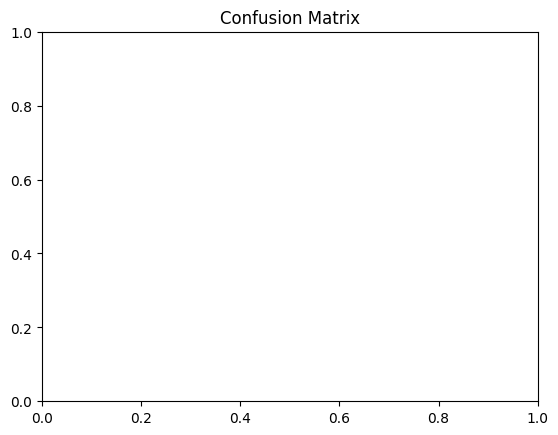

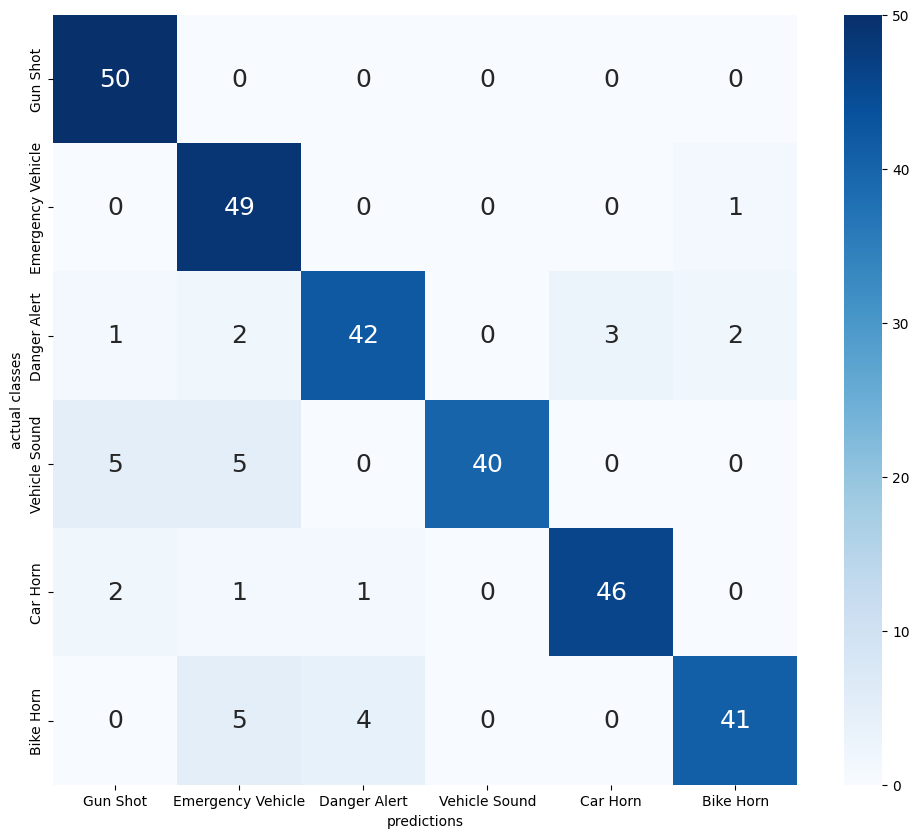

In [229]:
df = test_wav.copy()
result(df,preds)

In [230]:
df = pd.read_csv('./ensemble/Test_evaluation_all_ensemble.csv')

for i in range(len(result_preds)):
    if df['answer'][i] != df['predict'][i]:
        print(result_preds[i], df['answer'][i], df['predict'][i])

[0, 0.999814510345459, 0, 0, 0, 0.9998797178268433] 1 5
[0, 0, 0.3956116735935211, 0, 0.7459607720375061, 0] 2 4
[0.831063449382782, 0, 0.9938732385635376, 0, 0.9969732761383057, 0] 2 4
[1.0, 0.8427161574363708, 0.9888519644737244, 0, 0, 0] 2 0
[0, 0, 0.5495082139968872, 0.563544511795044, 0.999997615814209, 0] 2 4
[0.9990541338920593, 0, 0, 0, 0, 1.0] 2 5
[0, 0, 0, 0, 0.43609312176704407, 0.8521332144737244] 2 5
[0, 0.5102556347846985, 0.48310160636901855, 0, 0, 0] 2 1
[0.6472146511077881, 1.0, 0.964884877204895, 0, 0, 0] 2 1
[0, 0.998651921749115, 0, 0.5899739861488342, 0.8803365230560303, 0] 3 1
[0.9092729687690735, 0, 0, 0.79258793592453, 0, 0] 3 0
[0.7606476545333862, 0, 0, 0.7192217111587524, 0, 0] 3 0
[0.25050246715545654, 0.9999983310699463, 0, 0, 0.8821690082550049, 0] 3 1
[0.9988316893577576, 0, 0, 0.6755023896694183, 0, 0] 3 0
[0.9999637603759766, 0, 0.8228270411491394, 0, 0, 0] 3 0
[0, 0.9468331634998322, 0, 0.717719316482544, 0, 0] 3 1
[0, 0.8516085147857666, 0, 0.76636177